<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/intro_to_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Regularization: Ridge and Lasso

## L1 and L2 Regularization

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import zscore
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [16]:
dataset_url = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/auto-mpg.csv'

df = pd.read_csv(dataset_url, na_values=['NA', '?'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null int64
acceleration    398 non-null float64
year            398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


In [0]:
# impute <horsepower> missing values
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())
features = ['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin']
target = 'mpg'
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)

In [0]:
%matplotlib inline
from IPython.display import display, HTML

def report_coef(names, coef, intercept):
  r = pd.DataFrame({'coef': coef, 'positive': coef >= 0}, index = features)
  r = r.sort_values(by=['coef'])
  display(r)
  print(f'Intercep: {intercept}')
  r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

Final score (RMSE): 3.0019345985860784


,coef,positive
cylinders,-0.427721,False
weight,-0.007255,False
horsepower,-0.005491,False
displacement,0.020166,True
acceleration,0.138575,True
year,0.783047,True
origin,1.003762,True


Intercep: -19.101231042200034


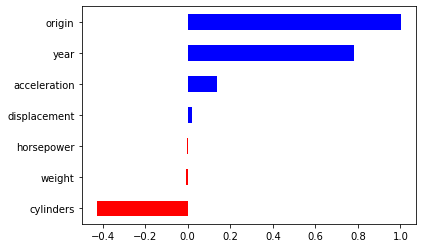

In [21]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
y_hat = lin_reg.predict(X_test)

score = np.sqrt(mean_squared_error(y_hat, y_test))
print(f"Final score (RMSE): {score}")

report_coef(features, lin_reg.coef_, lin_reg.intercept_)

## L1(Lasso) Regularization

Final score (RMSE): 3.0604021904033307


,coef,positive
cylinders,-0.427721,False
weight,-0.007255,False
horsepower,-0.005491,False
displacement,0.020166,True
acceleration,0.138575,True
year,0.783047,True
origin,1.003762,True


Intercep: -19.101231042200034


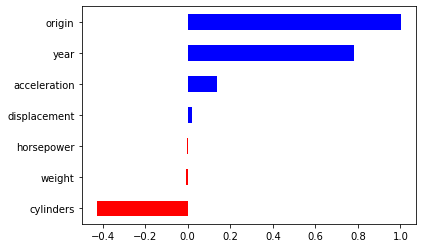

In [27]:
lasso_reg = Lasso(random_state=45, alpha=0.1)

lasso_reg.fit(X_train, y_train)
y_hat = lasso_reg.predict(X_test)

score = np.sqrt(mean_squared_error(y_hat, y_test))
print(f"Final score (RMSE): {score}")

report_coef(features, lin_reg.coef_, lin_reg.intercept_)

(1e-08, 100000000.0)

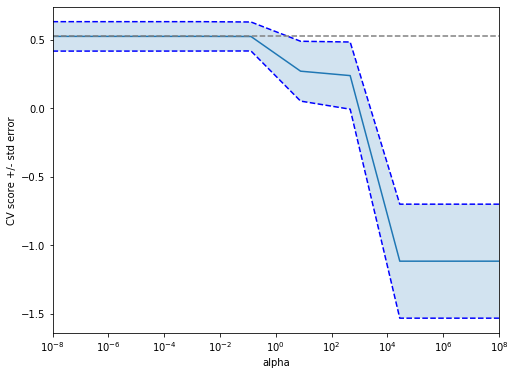

In [37]:
lasso_reg = Lasso(random_state=45)
alphas = np.logspace(-8, 8, 10)
scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
  lasso_reg.alpha = alpha
  this_scores = cross_val_score(lasso_reg, X, y, cv=n_folds, n_jobs=1)
  scores.append(np.mean(this_scores))
  scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])